# Test E & C Index calcs

In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index

In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
#warnings.filterwarnings('ignore')

# 1. Calculate CMIP Indeces

In [4]:
modelSet=_model.scenarioMip

In [5]:
modelSet

array([['CSIRO-ARCCSS', 'ACCESS-CM2', 'r1i1p1f1', 'r1i1p1f1'],
       ['CSIRO', 'ACCESS-ESM1-5', 'r1i1p1f1', 'r1i1p1f1'],
       ['AWI', 'AWI-CM-1-1-MR', 'r1i1p1f1', 'r1i1p1f1'],
       ['BCC', 'BCC-CSM2-MR', 'r1i1p1f1', 'r1i1p1f1'],
       ['CAMS', 'CAMS-CSM1-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['CAS', 'CAS-ESM2-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCAR', 'CESM2', 'r1i1p1f1', 'r10i1p1f1'],
       ['NCAR', 'CESM2-WACCM', 'r1i1p1f1', 'r1i1p1f1'],
       ['THU', 'CIESM', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-CM2-SR5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-ESM2', 'r1i1p1f1', 'r1i1p1f1'],
       ['CNRM-CERFACS', 'CNRM-CM6-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['CNRM-CERFACS', 'CNRM-ESM2-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['CCCma', 'CanESM5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CCCma', 'CanESM5-CanOE', 'r1i1p2f1', 'r1i1p2f1'],
       ['EC-Earth-Consortium', 'EC-Earth3', 'r1i1p1f1', 'r1i1p1f1'],
       ['EC-Earth-Consortium', 'EC-Earth3-CC', 'r1i1p1f1', 'r1i1p1f1'],
       ['

In [6]:
len(modelSet)

39

Climatology and piControl:

In [7]:
for iModel in [modelSet[3]]:
    
    print(iModel)
    
    try: 
        #sst
        controlXr = fh.loadModelData(iModel[1], 'ts_Amon', 'piControl', iModel[2])
        tsXr = fh.loadModelData(iModel[1], 'ts_Amon', 'historical', iModel[2])
        tradIndecesXr = xarray.open_dataset('results/cmipMonthlyIndeces/'+iModel[1]+'_historical.nc')
        
    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

['BCC' 'BCC-CSM2-MR' 'r1i1p1f1' 'r1i1p1f1']


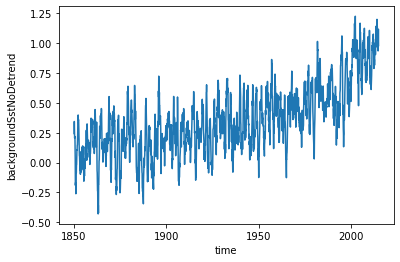

In [9]:
tradIndecesXr.backgroundSstNoDetrend.plot()

In [10]:
from eofs.xarray import Eof



In [11]:
sstMeanXr=controlXr.where(
    (controlXr.lat>-15) & (controlXr.lat<15) &
    (controlXr.lon>140) & (controlXr.lon<280),
    drop=True
).ts.groupby('time.month').mean(dim='time')

sstAnomXr=tsXr.where(
    (tsXr.lat>-15) & (tsXr.lat<15) &
    (tsXr.lon>140) & (tsXr.lon<280),
    drop=True
).ts.groupby('time.month'
            )-sstMeanXr-tradIndecesXr['backgroundSstNoDetrend']


sstAnomXr=sstAnomXr.where((sstAnomXr.month==1) + (sstAnomXr.month==2) + (
    sstAnomXr.month==12),
    drop=True)

/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [12]:
sstAnomXr

<xarray.DataArray (time: 0, lat: 26, lon: 124)>
dask.array<where, shape=(0, 26, 124), dtype=float64, chunksize=(0, 26, 124), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 
  * lat      (lat) float64 -14.02 -12.9 -11.78 -10.65 ... 10.65 11.78 12.9 14.02
  * lon      (lon) float64 140.6 141.8 142.9 144.0 ... 275.6 276.8 277.9 279.0
    month    (time) int64

In [13]:
import cartopy.crs as ccrs


In [14]:
def ensoPlotter(da, ax):
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt 
    
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [15]:
#there seems to be a bug in the Eof solver that doesn't handle dask very well,so pre calculating the result makes it work
sstAnomXr.load()

<xarray.DataArray (time: 0, lat: 26, lon: 124)>
array([], shape=(0, 26, 124), dtype=float64)
Coordinates:
  * time     (time) object 
  * lat      (lat) float64 -14.02 -12.9 -11.78 -10.65 ... 10.65 11.78 12.9 14.02
  * lon      (lon) float64 140.6 141.8 142.9 144.0 ... 275.6 276.8 277.9 279.0
    month    (time) int64

In [16]:
#although they don't really say this, I've applied an area weighting.

weights = numpy.cos(numpy.deg2rad(sstAnomXr.lat)
                ).values[..., numpy.newaxis]

In [17]:
solver=Eof(sstAnomXr, weights=weights)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:


eofsXr=solver.eofs(neofs=2) #only interested in first two modes

eofsXr.sel(mode=0)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [ ]:
def ensoPlotter(da, ax):
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [ ]:
fig=plt.figure(figsize=(18,12))

for mode in [0,1]:
    ax=fig.add_subplot(2,1,mode+1,
                       projection=ccrs.Miller(central_longitude=210))

    ensoPlotter(eofsXr.sel(mode=mode), ax)
    
    plt.title("mode " + str(mode))

In [ ]:
pcTimeXr=solver.pcs(pcscaling=1, npcs=2) #scaling 1: scaled to unit variance

In [ ]:
pcTimeXr.std('time')

In [ ]:
import utils.timePeriod as tp

In [ ]:
#pc1 = tp.averageForTimePeriod(pcTimeXr.sel(mode=0).rename('enso').to_dataset())
#pc2 = tp.averageForTimePeriod(pcTimeXr.sel(mode=1).rename('enso').to_dataset())

pc1 = pcTimeXr.sel(mode=0)
pc2 = pcTimeXr.sel(mode=1)

In [ ]:
import numpy.polynomial as poly

In [ ]:
pFit = poly.Polynomial.fit(pc1, pc2, 2)



In [ ]:
pFit.convert(domain=(-1, 1))

In [ ]:
alpha = pFit.convert(domain=(-1, 1)).coef[2]

In [ ]:
fig = plt.figure()

plt.scatter(pc1, pc2)

plt.plot(*pFit.linspace(), 'r')

In [ ]:
cXr=(pc1+pc2)/numpy.sqrt(2)
eXr=(pc1-pc2)/numpy.sqrt(2)

In [ ]:
cXr.plot()

In [ ]:
fig = plt.figure()

plt.scatter(cXr.values, eXr.values)

In [ ]:
%run ../utils/ecIndex.ipynb

In [ ]:
iModel

In [ ]:
eofSolver=solver(iModel)

In [ ]:
eofSolver.eofs()

In [ ]:
eXr, cXr, alpha = ecIndex(eofSolver)

In [ ]:
alpha